In [1]:
# Imports

import numpy as np
import imageio.v3 as iio

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from sklearn.metrics.pairwise import euclidean_distances

rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images


In [2]:
# Global variables

IMAGE_DIR = 'images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


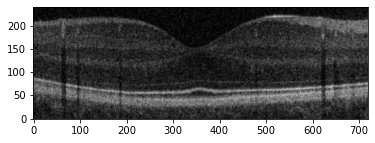

In [3]:
# Read, crop and display image and stats

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

In [4]:
class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta + self.dgamma), self.y + self.dr * np.sin(self.theta + self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1, p2]))
    def control_points(self):
        return self.bezier.control_points

    def path(self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch(self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')

    def intermediate_points(self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r / 8)))
        return self.bezier.point_at_t(np.linspace(0, 1, intervals))

    def approx_length(self):
        intermediates = self.intermediate_points()
        eds = euclidean_distances(intermediates, intermediates)
        return np.sum(np.diag(eds, 1))

    def colour_at_t(self, t, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1, 2)))
        colours = [image[point[0], point[1]] for point in intermediates]
        return np.array(colours) / 255

    # Added size and distance_to methods to the camo worm class to return worm size and distance between worms
    def size(self):
        return self.r
    
    def width(self):
        return width.r

    # Distance function calculated using Euclidean distance
    def distance_to(self, other_worm):
        distance = ((self.x - other_worm.x) ** 2 + (self.y - other_worm.y) ** 2) ** 0.5
        return distance

    # testing colour cost function
    def color_similarity(self, background_color):
        similarity = np.linalg.norm(self.colour - background_color)
        return similarity



    def average_background_color(self, image, radius):
        # Convert the coordinates to integers
        min_y = int(max(0, self.y - radius))
        max_y = int(min(image.shape[0], self.y + radius))
        min_x = int(max(0, self.x - radius))
        max_x = int(min(image.shape[1], self.x + radius))

        # Slice the image using integer indices
        background_pixels = image[min_y:max_y, min_x:max_x]

        # Calculate the average color
        avg_color = np.mean(background_pixels, axis=(0, 1))
        return avg_color


In [5]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms):
        try:
            self.add_patches([w.patch() for w in worms])
        except TypeError:
            self.add_patches([worms.patch()])

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)
        plt.show()


In [6]:
def random_worm(imshape, init_params):
    (ylim, xlim) = imshape
    midx = xlim * rng.random()
    midy = ylim * rng.random()
    r = init_params[0] * np.abs(rng.standard_normal())
    theta = rng.random() * np.pi
    dr = init_params[1] * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = init_params[2] * rng.standard_gamma(3)
    return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)

In [14]:
#Cost Functions separated

def distance_constraint(new_worm, existing_worms):
    for worm in existing_worms:
        if new_worm.distance_to(worm) < 10:
            return False
    return True

def size_constraint(new_worm):
    return new_worm.size() > 50 and new_worm.width <1

def color_constraint(new_worm, image, background_radius=0.5, color_threshold=50):
    #background_color = new_worm.average_background_color(image, background_radius)
    background_color = new_worm.average_background_color(image, background_radius)
    similarity = new_worm.color_similarity(background_color)
    return similarity < color_threshold

In [7]:
def combined_constraint(new_worm, existing_worms, image, background_radius=0.5, color_threshold=50):
    # Distance constraint
    for worm in existing_worms:
        if new_worm.distance_to(worm) < 10:
            return False
    
    # Size constraint
    if new_worm.size() <= 50 or new_worm.width >= 1:
        return False
    
    # Color constraint
    background_color = new_worm.average_background_color(image, background_radius)
    similarity = new_worm.color_similarity(background_color)
    if similarity >= color_threshold:
        return False
    
    return True


In [9]:
def initialise_clew(size, imshape, init_params):
    clew = []
    while True:
        new_worm = random_worm(imshape, init_params)
        #if distance_constraint(new_worm, clew) and size_constraint(new_worm) and color_constraint(new_worm, image):
        if combined_constraint(new_worm, clew, image):
            clew.append(new_worm)
            if len(clew) == size:
                return clew
            


Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


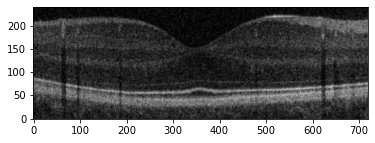

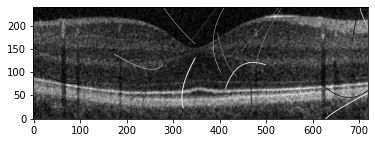

In [11]:
# Initialise clew and draw
image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

# Can change the number of worms, if functions keeps on running, try to modify this or the threshold as we might be trying to generate more worms than possible 
clew = initialise_clew(20, image.shape, (20, 30, 1))
drawing = Drawing(image)
drawing.add_worms(clew)
drawing.show()

In [12]:
import numpy as np

# Fitness function
def fitness_function(individual, existing_worms, image, background_radius=0.5, color_threshold=50):
    if combined_constraint(individual, existing_worms, image, background_radius, color_threshold):
        return 1 / (1 + combined_constraint_value(individual, existing_worms, image, background_radius, color_threshold))
    else:
        return 0

# Crossover function
def crossover(parent1, parent2):
    crossover_point = np.random.randint(1, len(parent1))
    child = parent1[:crossover_point] + parent2[crossover_point:]
    return child

# Mutation function
def mutate(individual, mutation_rate):
    mutated_individual = individual.copy()
    for i in range(len(mutated_individual)):
        if np.random.rand() < mutation_rate:
            mutated_individual[i] = np.random.uniform(0, 1)  # Example: Mutate the parameter with some randomness
    return mutated_individual

# Initialization function
def initialize_population(population_size, imshape):
    population = []
    for _ in range(population_size):
        individual = [np.random.uniform(0, 1) for _ in range(num_parameters)]  # Example: Randomly initialize parameters
        population.append(individual)
    return population

# Genetic algorithm
def genetic_algorithm(population_size, mutation_rate, generations, existing_worms, image, background_radius=0.5, color_threshold=50):
    population = initialize_population(population_size, imshape)
    for _ in range(generations):
        # Evaluate fitness of each individual
        fitness_scores = [fitness_function(individual, existing_worms, image, background_radius, color_threshold) for individual in population]

        # Select parents based on fitness scores
        parents = np.random.choice(population, size=population_size, p=fitness_scores / np.sum(fitness_scores), replace=True)

        # Create offspring through crossover and mutation
        offspring = []
        for i in range(population_size // 2):
            parent1, parent2 = parents[2 * i], parents[2 * i + 1]
            child1 = crossover(parent1, parent2)
            child2 = crossover(parent2, parent1)
            offspring.extend([mutate(child1, mutation_rate), mutate(child2, mutation_rate)])

        # Replace old population with offspring
        population = offspring

    # Return the best individual found
    best_individual = max(population, key=lambda ind: fitness_function(ind, existing_worms, image, background_radius, color_threshold))
    return best_individual


In [13]:
import numpy as np

def optimize(population_size, mutation_rate, generations, num_parameters):
    population = initialize_population(population_size, num_parameters)
    
    for _ in range(generations):
        offspring = []
        for _ in range(population_size):
            parent1, parent2 = np.random.choice(population, size=2, replace=False)
            child = crossover(parent1, parent2)
            child = mutate(child, mutation_rate)
            offspring.append(child)
        
        population = offspring
    
    # Find the best solution in the final population
    best_solution = min(population, key=combined_constraint)
    return best_solution

# Define your combined constraint function here
def combined_constraint(worm):
    return distance_constraint(worm) + size_constraint(worm) + color_constraint(worm)

# Define your initialization function here
def initialize_population(population_size, num_parameters):
    return [np.random.uniform(size=num_parameters) for _ in range(population_size)]

# Crossover Function
def crossover(parent1, parent2):
    crossover_point = np.random.randint(0, len(parent1))
    child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    return child

# Mutation Function
def mutate(individual, mutation_rate):
    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:
            individual[i] = np.random.rand()
    return individual


# Example usage:
best_solution = optimize(population_size=100, mutation_rate=0.1, generations=50, num_parameters=8)
print("Best Solution:", best_solution)


NameError: name 'optimize' is not defined

&copy; Cara MacNish, UWA, 2024